TODO:
 * precompute $\log|\Sigma_i|$
 * precomute swapped indices for parameter updates

In [1]:
using Distributions
using Seaborn
import CSV
import JLD2
import Base.Filesystem: joinpath

In [2]:
include("src/NGSIM.jl")

chmm_em! (generic function with 1 method)

In [3]:
DATA_PATH = "../data/trajdata_i101_trajectories-0750am-0805am"
JLD2.@load joinpath(DATA_PATH, "td.jld") td

(S, id_lookup) = td_sparse(td)

X_full = CSV.read(joinpath(DATA_PATH, "X.csv"); nullable=false)
X = Array(X_full[:, [:velocity, :heading]])'

(pairs, _) = readcsv(joinpath(DATA_PATH, "pairs.csv"), Int; header=true)
pairs = pairs'
;

In [4]:
plot(X[1, :], X[2, :], ".")
for i in 1:K
    plot(curr.μs[i][1],curr.μs[i][2], "X")
end

LoadError: [91mUndefVarError: K not defined[39m

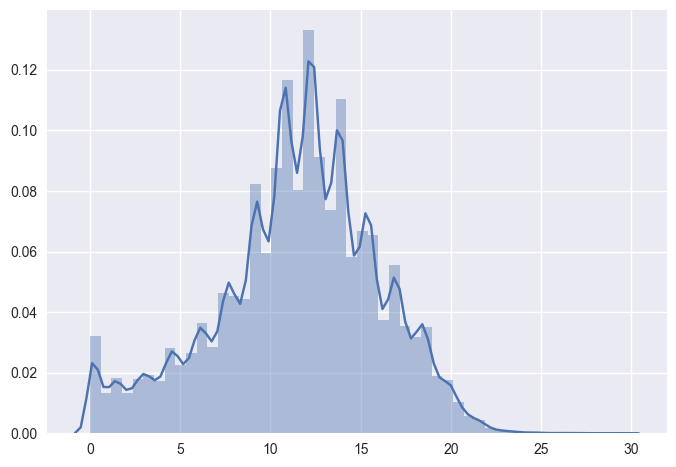

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000023CAA58>

In [5]:
distplot(X[1, :])

## EM

In [6]:
K = 5
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)
;

In [ ]:
(curr, log_like_hist) = chmm_em!(S, X, pairs, K, curr, suff; N_iters=20, print_every=1)

iteration      1:  -14965755.819
iteration      2:  1152736.315


In [9]:
plot(log_like_hist)

LoadError: [91mUndefVarError: log_like_hist not defined[39m

# Analysis

In [43]:
true_to_est_lut = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est_lut[i] = indmin(r)
end

In [51]:
P_true = copy(model.P)
P_hat = copy( curr.P[true_to_est_lut, true_to_est_lut, true_to_est_lut] )
vecnorm(P_true .- P_hat)

0.7542858027583378

In [52]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_lut] )
vecnorm(p0_true .- p0_hat)

0.260674987069303

In [53]:
hcat([model.μs[i] .- curr.μs[true_to_est_lut[i]] for i in 1:K] ...)

3×5 Array{Float64,2}:
 -0.00051745  -0.00585367  0.0127641   0.00533968   0.000901718
  0.00116878   0.0125749   0.00284204  0.00282913   0.00791609 
  0.00034659   0.00791029  0.0123829   0.00236185  -0.0124476  

In [55]:
vcat([vecnorm(model.Σs[i] .- curr.Σs[true_to_est_lut[i]]) for i in 1:K] ...)

5-element Array{Float64,1}:
 0.000492593
 0.0211899  
 0.0528093  
 0.00178972 
 0.0117793  